In [90]:
import os
import pandas as pd
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from IPython.display import clear_output
from keras.utils import to_categorical

%matplotlib notebook
sns.set_style('darkgrid')

In [83]:
fn = 'dataframe_tot_20181009113623.pkl'
df_tot = pickle.load(open(fn,'rb'))
plt.figure()
apps = ['vimeo','youtube','spotify','skype','whatsappvideo']
for app in apps:
    df_tot[df_tot.app==app].describe().iloc[1,:].plot()
df_tot.describe().iloc[1,:].plot()
apps.append('average')
plt.legend(apps)

In [137]:
max_len = 80
X_df = df_tot.iloc[:,0:max_len]
y = df_tot['app'] # or app_type
lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

# ONE-HOT VECTOR
one_hot_vector = True

if one_hot_vector:
    y = to_categorical(y)
    n_out = y.shape[1]
    model_loss = 'categorical_crossentropy'
else:
    n_out = 1
    model_loss = 'mae'
    
# SPLIT TRAIN TEST 
normalize = True
if normalize:
    x = StandardScaler().fit_transform(X_df.transpose()).transpose()
else:
    x = X_df.values

do_pca = False
n_comps = 60
if do_pca:
    principalComponents =  PCA(n_components=n_comps).fit_transform(x)
    x = pd.DataFrame(data = principalComponents, columns = ['pc' + str(ind+1) for ind in range(n_comps)]).values

X = x.reshape(x.shape[0],x.shape[1],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)


lstm_hidden = 200
epochs = 500
batch_samples = 50
model_optimizer = 'rmsprop'
metric = 'accuracy'

def LSTM_model():
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(lstm_hidden, 
                            input_shape=(None, X_train.shape[2]),
                            return_sequences=True,
                            return_state=False
                            ))
    
    model.add(keras.layers.LSTM(lstm_hidden, 
                            return_sequences=False,
                            return_state=False
                            ))
#     model.add(keras.layers.Dropout(.1))
    model.add((keras.layers.Dense(n_out,activation='softmax')))
    model.compile(loss=model_loss, optimizer=model_optimizer,metrics=[metric])
    return model

def NN_model():
    hidden_size = 200
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hidden_size, 
                            input_shape=(X_train.shape[1],),
                            ))
    model.add(keras.layers.Dense(hidden_size))
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(hidden_size))
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(hidden_size))          
    model.add((keras.layers.Dense(n_out,activation='softmax')))
    model.compile(loss=model_loss, optimizer=model_optimizer,metrics=[metric])
    return model

In [139]:
LSTM = False
if LSTM:
    model = LSTM_model()
else:
    model = NN_model()
    X = x.reshape(x.shape[0],x.shape[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 42)
    epochs = 100

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_samples, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=True)

Train on 917 samples, validate on 306 samples
Epoch 1/100
917/917 [==============================] - 3s 3ms/step - loss: 1.9927 - acc: 0.4329 - val_loss: 0.8801 - val_acc: 0.6078
Epoch 2/100
917/917 [==============================] - 0s 39us/step - loss: 1.2515 - acc: 0.5714 - val_loss: 0.7777 - val_acc: 0.6471
Epoch 3/100
917/917 [==============================] - 0s 37us/step - loss: 0.9900 - acc: 0.6336 - val_loss: 0.7545 - val_acc: 0.6830
Epoch 4/100
917/917 [==============================] - 0s 38us/step - loss: 0.9524 - acc: 0.6401 - val_loss: 0.6885 - val_acc: 0.7320
Epoch 5/100
917/917 [==============================] - 0s 40us/step - loss: 0.8360 - acc: 0.7001 - val_loss: 0.6571 - val_acc: 0.7386
Epoch 6/100
917/917 [==============================] - 0s 38us/step - loss: 0.8149 - acc: 0.6827 - val_loss: 0.6626 - val_acc: 0.7451
Epoch 7/100
917/917 [==============================] - 0s 43us/step - loss: 0.7899 - acc: 0.6870 - val_loss: 0.6611 - val_acc: 0.7516
Epoch 8/100
917/9

<IPython.core.display.Javascript object>


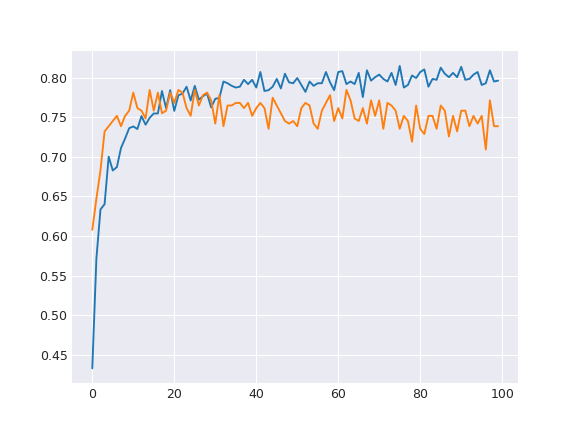

<IPython.core.display.Javascript object>


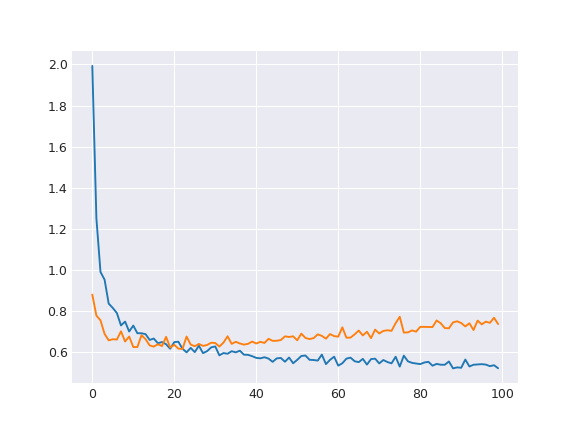

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_44 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 255       
Total para

In [140]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
model.summary()

In [135]:
fn = 'saved_models/history_'+ dt.datetime.now().strftime('%Y%m%d%H%M%S')+'.pkl'
with open(fn, 'wb') as handle:
    pickle.dump([history.params,history.history], handle, protocol=pickle.HIGHEST_PROTOCOL)
fn = 'saved_models/model_'+ dt.datetime.now().strftime('%Y%m%d%H%M%S')+'.h5'
model.save(fn)

In [97]:
# LOAD MODEL
from keras.models import load_model
model = load_model('saved_models/model_20181009102519.pkl')
history = pickle.load(open('saved_models/history_20181009102519.pkl','rb'))

<IPython.core.display.Javascript object>


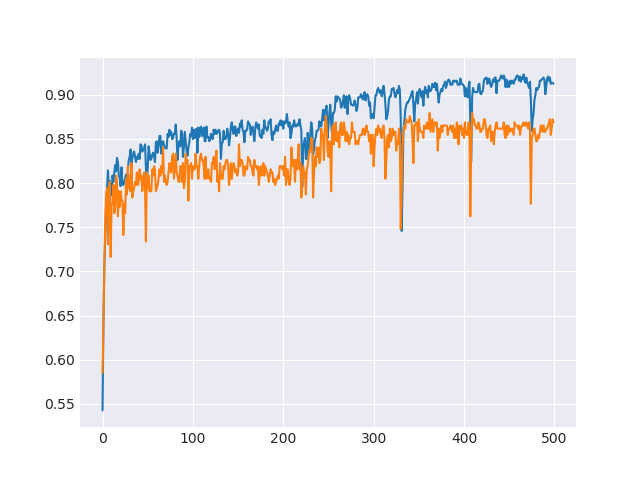

<IPython.core.display.Javascript object>


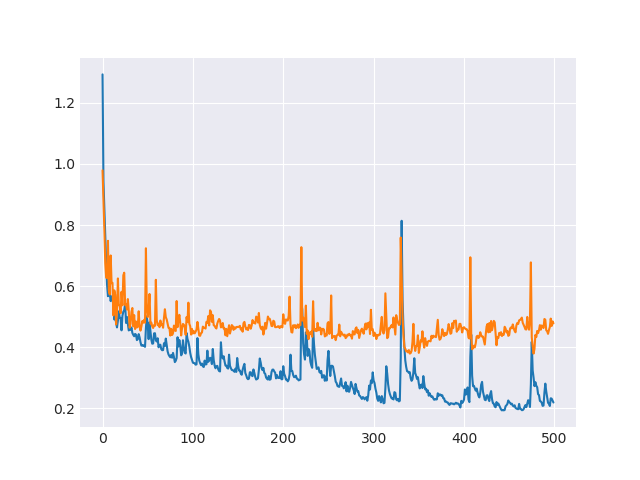

In [98]:
plt.figure()
plt.plot(history[1]['acc'])
plt.plot(history[1]['val_acc'])

plt.figure()
plt.plot(history[1]['loss'])
plt.plot(history[1]['val_loss'])

<IPython.core.display.Javascript object>


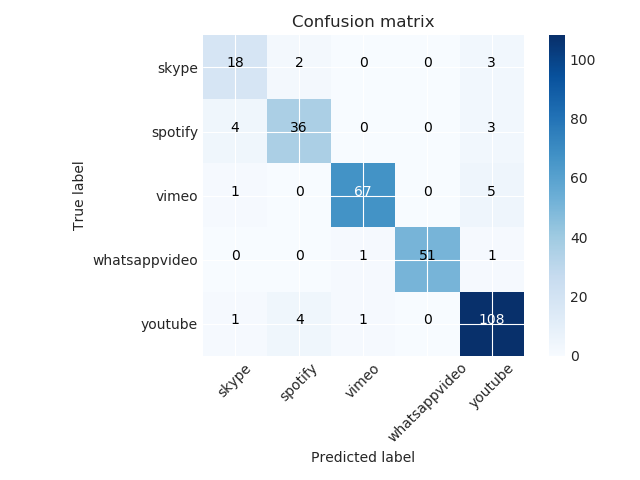

accuracy 91.50326797385621


In [32]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_pred = np.argmax(np.round(np.clip(model.predict(X_test),0,1)),axis=1)
y_test = np.argmax(y_test,axis=1)
plt.figure()
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=lab_enc.classes_, 
                      normalize=False,
                      title='Confusion matrix')
plt.show()

accuracy = cm.diagonal().sum()/cm.sum()*100
print('accuracy',accuracy)

/home/cttc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/cttc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<IPython.core.display.Javascript object>


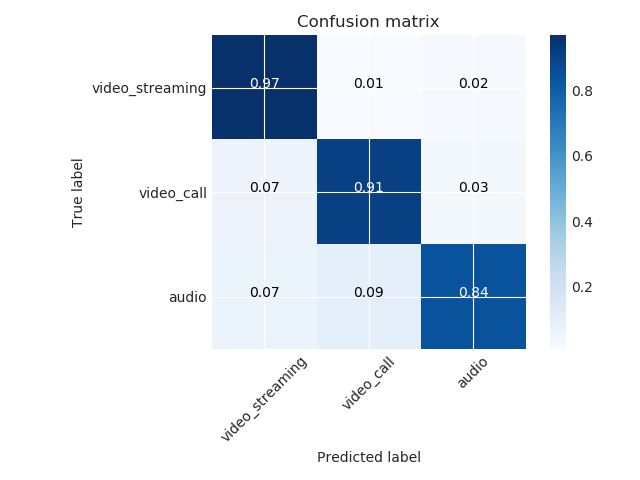

accuracy 93.4640522875817


In [46]:
app_type = {'vimeo':'video_streaming',
            'spotify':'audio',
            'youtube':'video_streaming',
            'skype':'video_call',
            'whatsappvideo':'video_call'}
app_type_class = {'video_streaming':0,
                  'video_call':1,
                  'audio':2}
y_pred_app_type = []
y_test_app_type = []

y_pred_app = lab_enc.inverse_transform(y_pred)
y_test_app = lab_enc.inverse_transform(y_test)

for y_t,y_p in zip(y_test_app,y_pred_app):
    y_pred_app_type.append(app_type_class[app_type[y_p]])
    y_test_app_type.append(app_type_class[app_type[y_t]])
    
plt.figure()
cm = confusion_matrix(y_test_app_type, y_pred_app_type)
plot_confusion_matrix(cm, 
                      classes=app_type_class.keys(), 
                      normalize=True,
                      title='Confusion matrix')
plt.show()

accuracy = cm.diagonal().sum()/cm.sum()*100
print('accuracy',accuracy)

In [42]:
app_type_class.values()[0]

TypeError: 'dict_values' object does not support indexing

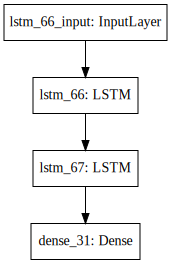

In [156]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(history.model).create(prog='dot', format='svg'))

In [155]:
history.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, None, 200)         161600    
_________________________________________________________________
lstm_67 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 1005      
Total params: 483,405
Trainable params: 483,405
Non-trainable params: 0
_________________________________________________________________


In [123]:
# ACCURACY CHECK

y_hat_int = []
y_test_int = []

y_hat = model.predict(X_test)

count = 0

if y_hat.shape[1]>1:
    for y_t in y_hat:
        y_hat_int.append(np.argmax(y_t))
    for y_t in y_test:
        y_test_int.append(np.where(y_t)[0][0])
else:
    for y_t in y_hat:
        y_hat_int.append(round(y_t[0]))
    for y_t in y_test:
        y_test_int.append(y_t)
for num,y_t in enumerate(y_hat_int):
    if y_t == y_test_int[num]:
        count = count + 1
print(count,count/len(y_test))

290 0.7591623036649214


In [48]:
model.__dict__

{'_built': True,
 '_container_nodes': {'dense_31_ib-0',
  'lstm_66_ib-0',
  'lstm_66_input_ib-0',
  'lstm_67_ib-0'},
 '_feed_input_names': ['lstm_66_input'],
 '_feed_inputs': [<tf.Tensor 'lstm_66_input_4:0' shape=(?, ?, 1) dtype=float32>],
 '_inbound_nodes': [<keras.engine.topology.Node at 0x7fc1a84b5160>],
 '_initial_weights': None,
 '_nodes_by_depth': {0: [<keras.engine.topology.Node at 0x7fc1a8065f98>],
  1: [<keras.engine.topology.Node at 0x7fc1a80207b8>],
  2: [<keras.engine.topology.Node at 0x7fc1a82a3518>],
  3: [<keras.engine.topology.Node at 0x7fc1a84b5550>]},
 '_outbound_nodes': [],
 '_output_mask_cache': {'140469728924392_94628092639856': None},
 '_output_shape_cache': {},
 '_output_tensor_cache': {},
 '_trainable': True,
 'input_layers': [<keras.engine.topology.InputLayer at 0x7fc1a85276a0>],
 'input_layers_node_indices': [0],
 'input_layers_tensor_indices': [0],
 'input_names': ['lstm_66_input'],
 'inputs': [<tf.Tensor 'lstm_66_input_4:0' shape=(?, ?, 1) dtype=float32>],
 

In [37]:
y_hat[0]

array([2.8766098], dtype=float32)

In [271]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
358/358 [==============================] - 8s 23ms/step - loss: 1.2766 - acc: 0.2793
Epoch 2/100
358/358 [==============================] - 5s 15ms/step - loss: 0.9042 - acc: 0.4050
Epoch 3/100
358/358 [==============================] - 5s 15ms/step - loss: 0.8727 - acc: 0.4497
Epoch 4/100
358/358 [==============================] - 5s 15ms/step - loss: 0.8200 - acc: 0.4972
Epoch 5/100
358/358 [==============================] - 5s 15ms/step - loss: 0.8011 - acc: 0.5307
Epoch 6/100
358/358 [==============================] - 5s 15ms/step - loss: 0.7551 - acc: 0.5642
Epoch 7/100
358/358 [==============================] - 5s 15ms/step - loss: 0.8623 - acc: 0.4693
Epoch 8/100
358/358 [==============================] - 5s 15ms/step - loss: 0.7861 - acc: 0.5335
Epoch 9/100
358/358 [==============================] - 5s 15ms/step - loss: 0.7390 - acc: 0.5726
Epoch 10/100
358/358 [==============================] - 5s 15ms/step - loss: 0.7128 - acc: 0.5866
Epoch 11/100
358/358 [=======

359/359 [==============================] - 5s 15ms/step - loss: 0.5065 - acc: 0.7298
Epoch 68/100
359/359 [==============================] - 5s 14ms/step - loss: 0.4805 - acc: 0.7326
Epoch 69/100
359/359 [==============================] - 5s 15ms/step - loss: 0.4747 - acc: 0.7354
Epoch 70/100
359/359 [==============================] - 5s 15ms/step - loss: 0.4764 - acc: 0.7326
Epoch 71/100
359/359 [==============================] - 5s 15ms/step - loss: 0.4712 - acc: 0.7354
Epoch 72/100
359/359 [==============================] - 5s 15ms/step - loss: 0.4815 - acc: 0.7270
Epoch 73/100
359/359 [==============================] - 5s 15ms/step - loss: 0.4726 - acc: 0.7382
Epoch 74/100
359/359 [==============================] - 5s 15ms/step - loss: 0.5021 - acc: 0.7187
Epoch 75/100
359/359 [==============================] - 5s 14ms/step - loss: 0.5361 - acc: 0.6936
Epoch 76/100
359/359 [==============================] - 5s 15ms/step - loss: 0.5104 - acc: 0.7075
Epoch 77/100
359/359 [===========

In [213]:
estimator.

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
